In [1]:
import os
os.environ["ROBOFLOW_API_KEY"] = "R4O2bcYasvX6aCflQ8UG"

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="R4O2bcYasvX6aCflQ8UG")
project = rf.workspace("turkiworkspace").project("cv_project_v2-65m1l")
version = project.version(1)
dataset = version.download("folder")

print("Dataset location:", dataset.location)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 41.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to CV_Project_v2-1 in folder:: 100%|██████████| 385/385 [00:00<00:00, 3082.22it/s]

Dataset location: /content/CV_Project_v2-1


In [3]:
print(os.listdir(dataset.location))

['train', 'valid', 'README.dataset.txt', 'README.roboflow.txt', 'test']


In [4]:
from torchvision import datasets, transforms

root = "/content/CV_Project_v2-1"
ds = datasets.ImageFolder(os.path.join(root, "train"), transform=transforms.ToTensor())
print("Detected classes:", ds.classes)

Detected classes: ['Clean', 'Partially_Eaten', 'Uneaten']


In [5]:
import os, glob
root="/content/CV_Project_v2-1"
for split in ["train","valid","test"]:
    for cls in ["Clean","Partially_Eaten","Uneaten"]:
        p=os.path.join(root, split, cls)
        n=len(glob.glob(p+"/*"))
        print(split, cls, n)

train Clean 102
train Partially_Eaten 117
train Uneaten 93
valid Clean 10
valid Partially_Eaten 11
valid Uneaten 10
test Clean 8
test Partially_Eaten 10
test Uneaten 10


# MobileNetV3:
Two-Stage Transfer Learning

Freeze -> Unfreeze last 2 blocks

Light Augmentation


In [6]:
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from sklearn.metrics import classification_report, confusion_matrix

In [7]:
DATA_DIR = "/content/CV_Project_v2-1"
IMG_SIZE = 224
BATCH_SIZE = 16
NUM_WORKERS = 0

STAGE1_EPOCHS = 6
STAGE2_EPOCHS = 18

LR_STAGE1 = 1e-3
LR_STAGE2 = 5e-5
WEIGHT_DECAY = 5e-4
LABEL_SMOOTHING = 0.1
SEED = 42

OUT_DIR = "/content/outputs_mobilenet"

In [8]:
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
os.makedirs(OUT_DIR, exist_ok=True)

root = Path(DATA_DIR)
train_dir = root / "train"
valid_dir = root / ("valid" if (root / "valid").exists() else "val")
test_dir  = root / "test"

print("Device:", device)
print("Train:", train_dir, train_dir.exists())
print("Valid:", valid_dir, valid_dir.exists())
print("Test :", test_dir,  test_dir.exists())

Device: cuda
Train: /content/CV_Project_v2-1/train True
Valid: /content/CV_Project_v2-1/valid True
Test : /content/CV_Project_v2-1/test True


## Transforms

In [9]:
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.80, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.20, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225)),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225)),
])

## Datasets & Loaders

In [10]:
train_ds = datasets.ImageFolder(str(train_dir), transform=train_tfms)
valid_ds = datasets.ImageFolder(str(valid_dir), transform=eval_tfms)
test_ds  = datasets.ImageFolder(str(test_dir),  transform=eval_tfms)

print("Classes:", train_ds.classes)
print("Sizes | train:", len(train_ds), "valid:", len(valid_ds), "test:", len(test_ds))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=(device=="cuda"))
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=(device=="cuda"))
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=(device=="cuda"))

Classes: ['Clean', 'Partially_Eaten', 'Uneaten']
Sizes | train: 312 valid: 31 test: 28


## Model

In [11]:
model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)

# replace classifier head
in_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_features, len(train_ds.classes))
model = model.to(device)

def set_requires_grad(module, flag: bool):
    for p in module.parameters():
        p.requires_grad = flag

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 203MB/s]


## Class Weights + Label Smoothing

In [12]:
manual_weights = torch.tensor(
    [1.0, 1.6, 1.0],   # Clean, Partially_Eaten, Uneaten
    dtype=torch.float32
).to(device)

criterion = nn.CrossEntropyLoss(
    weight=manual_weights,
    label_smoothing=0.1
)

print("Using manual class weights:", manual_weights.tolist())

Using manual class weights: [1.0, 1.600000023841858, 1.0]


## Train/Eval Functions

In [13]:
@torch.no_grad()
def evaluate(loader):
    model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        loss_sum += loss.item() * x.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return loss_sum / max(total, 1), correct / max(total, 1)
def train_one_epoch(optimizer):
    model.train()
    loss_sum, correct, total = 0.0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * x.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return loss_sum / max(total, 1), correct / max(total, 1)

## Stage 1: Freeze backbone

In [14]:
print("\n===== STAGE 1: Freeze backbone, train head only =====")
set_requires_grad(model.features, False)
set_requires_grad(model.classifier, True)

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                              lr=LR_STAGE1, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=STAGE1_EPOCHS)

best_val_acc = 0.0
best_path = os.path.join(OUT_DIR, "best_mobilenetv3_small_freeze_unfreeze_v2.pt")

for epoch in range(1, STAGE1_EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(optimizer)
    va_loss, va_acc = evaluate(valid_loader)
    scheduler.step()
    print(f"[S1] Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | valid loss {va_loss:.4f} acc {va_acc:.4f}")

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save({
            "model": model.state_dict(),
            "classes": train_ds.classes,
            "img_size": IMG_SIZE,
            "arch": "mobilenet_v3_small_torchvision_freeze_unfreeze_v2"
        }, best_path)
        print("✅ Saved best:", best_path)


===== STAGE 1: Freeze backbone, train head only =====
[S1] Epoch 01 | train loss 0.6539 acc 0.7372 | valid loss 0.5621 acc 0.9032
✅ Saved best: /content/outputs_mobilenet/best_mobilenetv3_small_freeze_unfreeze_v2.pt
[S1] Epoch 02 | train loss 0.4143 acc 0.9455 | valid loss 0.4165 acc 0.9677
✅ Saved best: /content/outputs_mobilenet/best_mobilenetv3_small_freeze_unfreeze_v2.pt
[S1] Epoch 03 | train loss 0.3995 acc 0.9583 | valid loss 0.3780 acc 1.0000
✅ Saved best: /content/outputs_mobilenet/best_mobilenetv3_small_freeze_unfreeze_v2.pt
[S1] Epoch 04 | train loss 0.3593 acc 0.9744 | valid loss 0.3614 acc 1.0000
[S1] Epoch 05 | train loss 0.3476 acc 0.9840 | valid loss 0.3869 acc 0.9677
[S1] Epoch 06 | train loss 0.3485 acc 0.9840 | valid loss 0.3700 acc 0.9677


## Stage 2: Unfreeze last 2 blocks ONLY

In [15]:
print("\n===== STAGE 2: Unfreeze last 2 feature blocks + fine-tune =====")
set_requires_grad(model.features, False)
for block in model.features[-1:]:
    set_requires_grad(block, True)
set_requires_grad(model.classifier, True)

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                              lr=LR_STAGE2, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=STAGE2_EPOCHS)

for epoch in range(1, STAGE2_EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(optimizer)
    va_loss, va_acc = evaluate(valid_loader)
    scheduler.step()
    print(f"[S2] Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | valid loss {va_loss:.4f} acc {va_acc:.4f}")

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save({
            "model": model.state_dict(),
            "classes": train_ds.classes,
            "img_size": IMG_SIZE,
            "arch": "mobilenet_v3_small_torchvision_freeze_unfreeze_v2"
        }, best_path)
        print("✅ Saved best:", best_path)

print("\nBest valid acc:", best_val_acc)
print("Best checkpoint:", best_path)


===== STAGE 2: Unfreeze last 2 feature blocks + fine-tune =====
[S2] Epoch 01 | train loss 0.3647 acc 0.9776 | valid loss 0.3770 acc 0.9677
[S2] Epoch 02 | train loss 0.3470 acc 0.9808 | valid loss 0.3700 acc 0.9677
[S2] Epoch 03 | train loss 0.3475 acc 0.9840 | valid loss 0.3909 acc 0.9677
[S2] Epoch 04 | train loss 0.3570 acc 0.9840 | valid loss 0.3953 acc 0.9677
[S2] Epoch 05 | train loss 0.3404 acc 0.9936 | valid loss 0.4016 acc 0.9677
[S2] Epoch 06 | train loss 0.3462 acc 0.9872 | valid loss 0.3877 acc 0.9677
[S2] Epoch 07 | train loss 0.3457 acc 0.9808 | valid loss 0.3869 acc 0.9677
[S2] Epoch 08 | train loss 0.3616 acc 0.9776 | valid loss 0.3911 acc 0.9677
[S2] Epoch 09 | train loss 0.3446 acc 0.9872 | valid loss 0.3958 acc 0.9677
[S2] Epoch 10 | train loss 0.3287 acc 1.0000 | valid loss 0.3911 acc 0.9677
[S2] Epoch 11 | train loss 0.3605 acc 0.9776 | valid loss 0.3956 acc 0.9677
[S2] Epoch 12 | train loss 0.3546 acc 0.9904 | valid loss 0.3914 acc 0.9677
[S2] Epoch 13 | train l

## Test Evaluation (best checkpoint)

In [16]:
ckpt = torch.load(best_path, map_location="cpu")
model.load_state_dict(ckpt["model"])
model = model.to(device).eval()

## Test evaluation WITH confidence threshold

In [17]:
print("Class order:", train_ds.classes)

Class order: ['Clean', 'Partially_Eaten', 'Uneaten']


In [18]:
CLEAN_IDX = train_ds.classes.index("Clean")
PARTIAL_IDX = train_ds.classes.index("Partially_Eaten")
UNEATEN_IDX = train_ds.classes.index("Uneaten")

TH_CLEAN = 0.60
TH_UNEATEN = 0.60

y_true, y_pred = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)

        probs = torch.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)

        for i in range(len(preds)):
            pred = preds[i].item()

            # ---- Confidence Threshold Rules ----
            if pred == CLEAN_IDX and probs[i, CLEAN_IDX] < TH_CLEAN:
                pred = PARTIAL_IDX

            if pred == UNEATEN_IDX and probs[i, UNEATEN_IDX] < TH_UNEATEN:
                pred = PARTIAL_IDX

            y_pred.append(pred)

        y_true.extend(y.tolist())

print("\nTEST Classification report (with confidence threshold):\n")
print(classification_report(y_true, y_pred, target_names=test_ds.classes, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))


TEST Classification report (with confidence threshold):

                 precision    recall  f1-score   support

          Clean     1.0000    1.0000    1.0000         8
Partially_Eaten     0.9091    1.0000    0.9524        10
        Uneaten     1.0000    0.9000    0.9474        10

       accuracy                         0.9643        28
      macro avg     0.9697    0.9667    0.9666        28
   weighted avg     0.9675    0.9643    0.9642        28

Confusion matrix:
 [[ 8  0  0]
 [ 0 10  0]
 [ 0  1  9]]


# Grad-CAM

In [19]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

In [20]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.fwd_handle = target_layer.register_forward_hook(self._forward_hook)
        self.bwd_handle = target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        self.activations = out

    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_tensor, class_idx):
        self.model.zero_grad(set_to_none=True)
        output = self.model(input_tensor)
        score = output[:, class_idx]
        score.backward()

        grads = self.gradients.detach()
        acts = self.activations.detach()

        weights = grads.mean(dim=(2, 3), keepdim=True)
        cam = (weights * acts).sum(dim=1)
        cam = F.relu(cam)

        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        return cam

## preprocessing image for Grad-cam

In [21]:
eval_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225)),
])

target_layer = model.features[-1]
gradcam = GradCAM(model, target_layer)

In [22]:
def gradcam_single(img_path):
    img = Image.open(img_path).convert("RGB")
    input_tensor = eval_tfms(img).unsqueeze(0).to(device)

    model.eval()
    logits = model(input_tensor)
    pred_class = logits.argmax(dim=1).item()

    cam = gradcam.generate(input_tensor, pred_class)[0].cpu().numpy()
    cam = cv2.resize(cam, (224, 224))

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    orig = np.array(img.resize((224, 224)))
    overlay = np.clip(0.4 * heatmap + 0.6 * orig, 0, 255).astype(np.uint8)

    return orig, heatmap, overlay, train_ds.classes[pred_class]

In [23]:
def show_three_gradcams(clean_path, partial_path, uneaten_path):
    paths = [
        ("Clean", clean_path),
        ("Partially_Eaten", partial_path),
        ("Uneaten", uneaten_path),
    ]

    fig, axes = plt.subplots(3, 3, figsize=(12, 10))

    for row, (true_label, path) in enumerate(paths):
        orig, cam, overlay, pred = gradcam_single(path)

        axes[row, 0].imshow(orig)
        axes[row, 0].set_title(f"{true_label} | Original")
        axes[row, 0].axis("off")

        axes[row, 1].imshow(cam)
        axes[row, 1].set_title("Grad-CAM")
        axes[row, 1].axis("off")

        axes[row, 2].imshow(overlay)
        axes[row, 2].set_title(f"Overlay (Pred: {pred})")
        axes[row, 2].axis("off")

    plt.tight_layout()
    plt.show()

In [24]:
def show_three_gradcams(clean_path, partial_path, uneaten_path):
    paths = [
        ("Clean", clean_path),
        ("Partially_Eaten", partial_path),
        ("Uneaten", uneaten_path),
    ]

    fig, axes = plt.subplots(3, 3, figsize=(12, 10))

    for row, (true_label, path) in enumerate(paths):
        orig, cam, overlay, pred = gradcam_single(path)

        axes[row, 0].imshow(orig)
        axes[row, 0].set_title(f"{true_label} | Original")
        axes[row, 0].axis("off")

        axes[row, 1].imshow(cam)
        axes[row, 1].set_title("Grad-CAM")
        axes[row, 1].axis("off")

        axes[row, 2].imshow(overlay)
        axes[row, 2].set_title(f"Overlay (Pred: {pred})")
        axes[row, 2].axis("off")

    plt.tight_layout()
    plt.show()


Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.


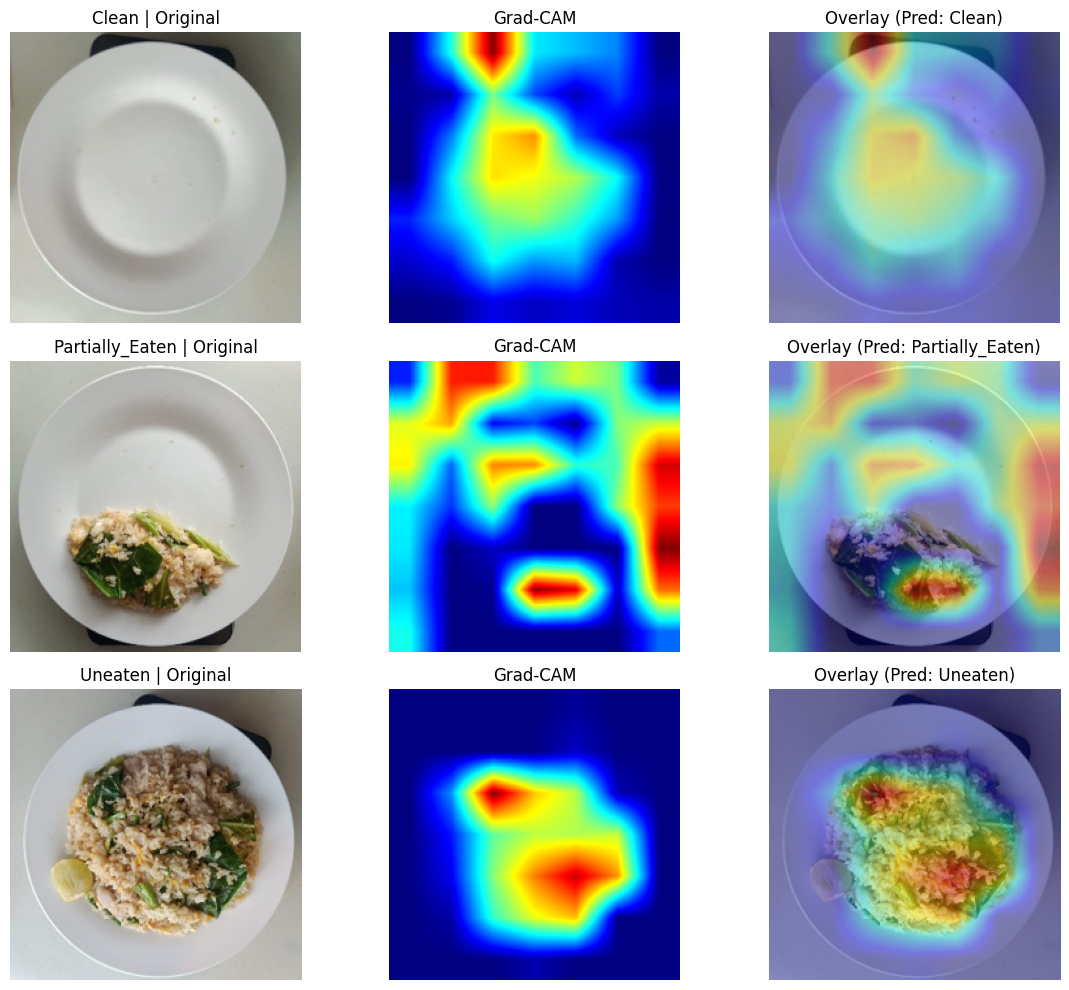

In [26]:
clean_img = "/content/c.jpeg"
partial_img = "/content/pe1.jpeg"
uneaten_img = "/content/ue.jpeg"

show_three_gradcams(clean_img, partial_img, uneaten_img)


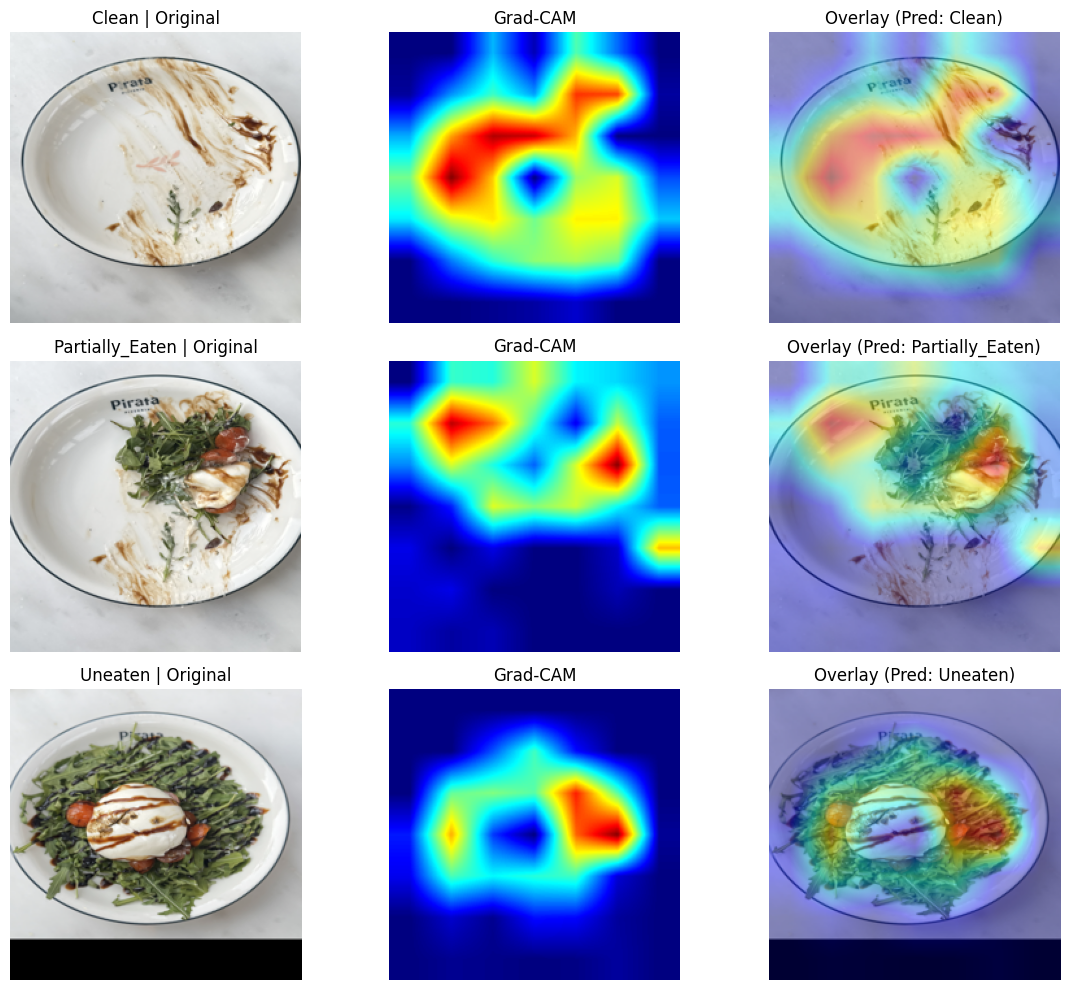

In [27]:
clean_img = "/content/clean.png"
partial_img = "/content/pe2.png"
uneaten_img = "/content/ue2.png"

show_three_gradcams(clean_img, partial_img, uneaten_img)

# Save the model:

In [31]:
import torch

save_path = "best_MN.pt"

torch.save({
    "model_state": model.state_dict(),
    "classes": train_ds.classes,     # ['Clean','Partially_Eaten','Uneaten']
    "img_size": 224,
    "arch": "mobilenet_v3_small",
}, save_path)

print("Saved PyTorch:", save_path)

Saved PyTorch: best_MN.pt


In [32]:
import torch
import torch.nn as nn
from torchvision import models

ckpt = torch.load("best_MN.pt", map_location="cpu")

model = models.mobilenet_v3_small(weights=None)
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, len(ckpt["classes"]))
model.load_state_dict(ckpt["model_state"])
model.eval()

classes = ckpt["classes"]
print("Loaded PyTorch, classes:", classes)

Loaded PyTorch, classes: ['Clean', 'Partially_Eaten', 'Uneaten']
